In [1]:
from ISLP import load_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from alibi.explainers import Counterfactual
import shap
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret import show
from interpret.glassbox import ExplainableBoostingRegressor, ExplainableBoostingClassifier

In [2]:
tf.compat.v1.reset_default_graph()

In [3]:
boston = load_data('Boston')
boston = boston.rename({'medv':'price'}, axis=1)
boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


In [4]:
X = boston.drop('price', axis=1)
y = boston['price']
X.shape, y.shape

((506, 12), (506,))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 12), (102, 12), (404,), (102,))

In [21]:
model = XGBRegressor(n_estimators=100, max_depth=2, random_state=0)
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9790719198572576, 0.7594666321433174)

In [22]:
explainer = shap.Explainer(model)
explanation = explainer(X_test, check_additivity=False)
explanation

.values =
array([[ 0.6001106 ,  0.02226779,  1.0354466 , ..., -0.57922477,
         0.92376   ,  3.0444975 ],
       [ 0.9494226 ,  0.03010344, -0.16729373, ..., -0.35846126,
        -1.1350354 ,  2.2349408 ],
       [ 0.46646056,  0.03010344, -0.18186387, ...,  0.40742064,
         1.4644355 , -0.6426971 ],
       ...,
       [ 0.1288153 , -0.1193731 , -0.4505401 , ..., -0.29992837,
         0.59225833, -0.83730143],
       [ 0.12442684,  0.02226779, -0.18186387, ...,  0.3694702 ,
         0.48199937,  1.3832649 ],
       [ 0.5344569 ,  0.03010344, -0.28500775, ..., -0.3695404 ,
        -1.2509247 , -0.85012037]], dtype=float32)

.base_values =
array([22.613903, 22.613903, 22.613903, 22.613903, 22.613903, 22.613903,
       22.613903, 22.613903, 22.613903, 22.613903, 22.613903, 22.613903,
       22.613903, 22.613903, 22.613903, 22.613903, 22.613903, 22.613903,
       22.613903, 22.613903, 22.613903, 22.613903, 22.613903, 22.613903,
       22.613903, 22.613903, 22.613903, 22.613903, 22.

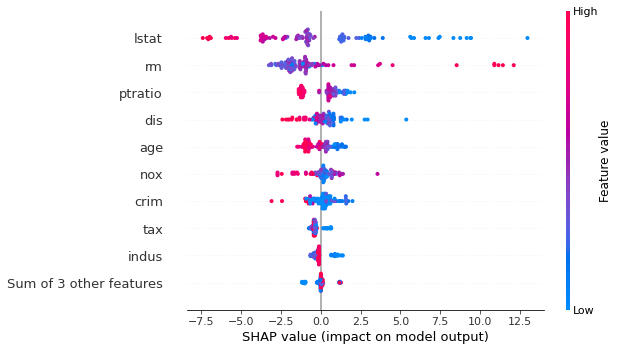

In [23]:
shap.plots.beeswarm(explanation)

In [29]:
if isinstance(explanation.values, list) or len(explanation.values.shape) == 3:
    class_index_to_explain = 1
    shap_values_2d = explanation.values[:, :, class_index_to_explain]
    print(f"분류 문제: {class_index_to_explain}번 클래스에 대한 중요도를 계산합니다.")
else:
    # 회귀 문제일 경우
    shap_values_2d = explanation.values
    print("회귀 문제: 피처 중요도를 계산합니다.")

feature_names = X_test.columns
mean_abs_shap = np.abs(shap_values_2d).mean(axis=0)
feature_importance_df = pd.DataFrame({'feature':feature_names, 'importance':mean_abs_shap}).sort_values('importance', ascending=False)
feature_importance_df

회귀 문제: 피처 중요도를 계산합니다.


,feature,importance
11,lstat,3.198065
5,rm,2.129751
10,ptratio,1.004912
7,dis,0.732664
6,age,0.721230
4,nox,0.603221
0,crim,0.567478
9,tax,0.410287
2,indus,0.368948
8,rad,0.160336
